In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


In [2]:
train_path = "../input/competitive-data-science-predict-future-sales/sales_train.csv"
test_path = "../input/competitive-data-science-predict-future-sales/test.csv"
items_path = "../input/competitive-data-science-predict-future-sales/items.csv"
shops_path = "../input/competitive-data-science-predict-future-sales/shops.csv"
item_cat_path = "../input/competitive-data-science-predict-future-sales/item_categories.csv"

In [3]:
items = pd.read_csv(items_path)
cats = pd.read_csv(item_cat_path)
shops = pd.read_csv(shops_path)
train = pd.read_csv( train_path )
test = pd.read_csv( test_path )

In [4]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [5]:
cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [6]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [7]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [8]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


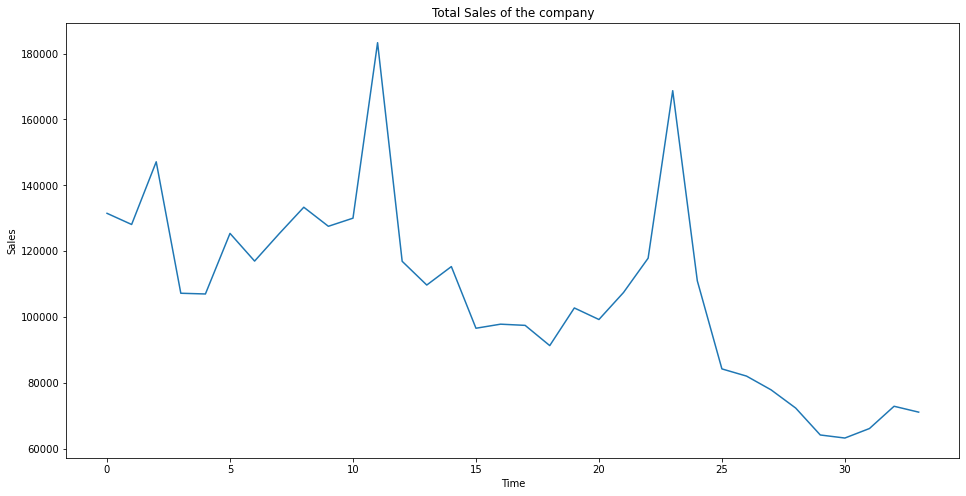

In [9]:
import matplotlib.pyplot as plt
ts=train.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

上のグラフより、トレンド、季節性による影響があるということがわかる。  

# 学習器の選択
統計ベースの時系列分析手法(AR,ARIMA,SARIMAモデル)をそのまま利用するのではなく、これらの手法の考え方を特徴量に落とし込み、そして売上げデータの他に、多くあるデータセットのデータ(商品の値段、商品名、商品のカテゴリ、店名、店のカテゴリなど)から重要なデータを取り出した後、それらの特徴量から、特徴量エンジニアリングを通し有効な特徴量を作成し、勾配ブースティングをデータ分析を行いました。

## 探索的データ分析(Exploratory Data Analysis)

In [10]:
import catboost
import matplotlib.pyplot as plt
# from sklearn.preprocessing import train_test_split as split
import seaborn as sns


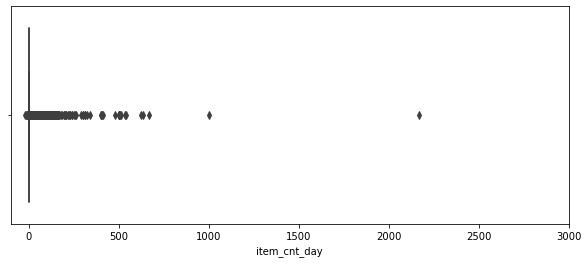

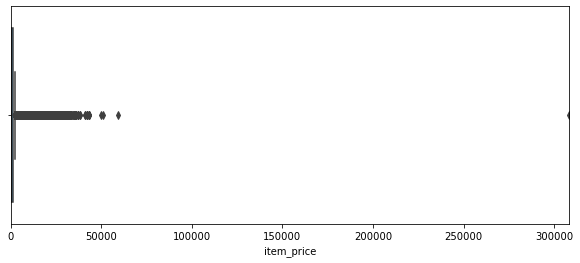

2935849
2
12
1
2935846


In [11]:

plt.figure(figsize = (10,4))
plt.xlim(-100, 3000)
sns.boxplot( x= train.item_cnt_day )
plt.figure( figsize = (10,4) )
plt.xlim(train.item_price.min(), train.item_price.max())
sns.boxplot( x = train.item_price )
plt.show()
print(train.shape[0])
print(len( train[train.item_cnt_day >999 ] ))
print( len(train[ train.item_cnt_day > 500  ]) )
print(len(train[train.item_price >100000 ]))
train = train[(train.item_price < 100000 )& (train.item_cnt_day < 1000)]
print(train.shape[0])


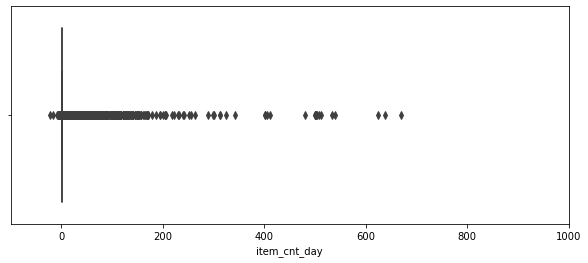

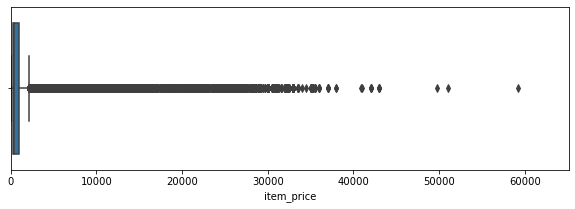

In [12]:
plt.figure(figsize = (10,4))
plt.xlim( -100, 1000 )
sns.boxplot( x= train.item_cnt_day )
plt.figure( figsize = (10,3) )
plt.xlim( train.item_price.min(), train.item_price.max()*1.1 )
sns.boxplot( x = train.item_price )
plt.show()

In [13]:
train = train[train.item_price > 0].reset_index(drop = True)
train.loc[train.item_cnt_day < 1, "item_cnt_day"] = 0#train.item_cnt_day < 1の場所は全て0とした。

### shopsの特徴量エンジニアリング

In [14]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [15]:
#shopsから店の場所の情報とカテゴリの情報を取り出す。
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )#cityとして、
shops["category"] = shops.shop_name.str.split(" ").map( lambda x: x[1] )
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"


In [16]:
shops.head()

,shop_name,shop_id,city,category
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,"Орджоникидзе,"
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,ТЦ
2,"Адыгея ТЦ ""Мега""",2,Адыгея,ТЦ
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,ТРК
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,ТЦ


In [17]:
shops.category.value_counts()

ТЦ                27
ТРЦ               11
ТК                 5
ТРК                5
Орджоникидзе,      2
ул.                2
ЧС                 1
"Распродажа"       1
Торговля           1
Магазин            1
склад              1
Посад              1
(Плехановская,     1
МТРЦ               1
Name: category, dtype: int64

In [18]:
#特徴量のlabelエンコーディングを行う。ここで、頻出度が小さいものはまとめてotherとする。
category = []
for cat in shops.category.unique():
    print(cat, len(shops[shops.category == cat]) )
    if len(shops[shops.category == cat]) > 4:
        category.append(cat)

Орджоникидзе, 2
ТЦ 27
ТРК 5
ТРЦ 11
(Плехановская, 1
Торговля 1
ул. 2
ЧС 1
"Распродажа" 1
МТРЦ 1
Магазин 1
ТК 5
Посад 1
склад 1


In [19]:
shops.category = shops.category.apply( lambda x: x if (x in category) else "other" )

In [20]:
shops["city"].value_counts()

Москва              13
Якутск               4
Тюмень               3
РостовНаДону         3
Воронеж              3
Самара               2
Казань               2
Жуковский            2
Красноярск           2
Уфа                  2
Н.Новгород           2
СПб                  2
Новосибирск          2
Выездная             1
Омск                 1
Калуга               1
Томск                1
Сергиев              1
Цифровой             1
Балашиха             1
Адыгея               1
Сургут               1
Чехов                1
Вологда              1
Ярославль            1
Коломна              1
Волжский             1
Мытищи               1
Химки                1
Курск                1
Интернет-магазин     1
Name: city, dtype: int64

In [21]:
shop_kind = []
for shop in shops.city.unique():
    print(shop, len(shops[shops.city == shop]) )
    if len(shops[shops.city == shop]) > 1:
        shop_kind.append(shop)
shops.city = shops.category.apply( lambda x: x if (x in shop_kind ) else "other" )

Якутск 4
Адыгея 1
Балашиха 1
Волжский 1
Вологда 1
Воронеж 3
Выездная 1
Жуковский 2
Интернет-магазин 1
Казань 2
Калуга 1
Коломна 1
Красноярск 2
Курск 1
Москва 13
Мытищи 1
Н.Новгород 2
Новосибирск 2
Омск 1
РостовНаДону 3
СПб 2
Самара 2
Сергиев 1
Сургут 1
Томск 1
Тюмень 3
Уфа 2
Химки 1
Цифровой 1
Чехов 1
Ярославль 1


In [22]:
shops.head()

,shop_name,shop_id,city,category
0,"!Якутск Орджоникидзе, 56 фран",0,other,other
1,"!Якутск ТЦ ""Центральный"" фран",1,other,ТЦ
2,"Адыгея ТЦ ""Мега""",2,other,ТЦ
3,"Балашиха ТРК ""Октябрь-Киномир""",3,other,ТРК
4,"Волжский ТЦ ""Волга Молл""",4,other,ТЦ


In [23]:
from sklearn.preprocessing import LabelEncoder
shops["shop_category"] = LabelEncoder().fit_transform( shops.category )
shops["shop_city"] = LabelEncoder().fit_transform( shops.city )

In [24]:
shops = shops[["shop_id", "shop_category", "shop_city"]]

In [25]:
shops.head()

,shop_id,shop_category,shop_city
0,0,0,0
1,1,4,0
2,2,4,0
3,3,2,0
4,4,4,0


### categoryの特徴量エンジニアリング

In [26]:
cats.item_category_name

0       PC - Гарнитуры/Наушники
1              Аксессуары - PS2
2              Аксессуары - PS3
3              Аксессуары - PS4
4              Аксессуары - PSP
                ...            
79                    Служебные
80           Служебные - Билеты
81      Чистые носители (шпиль)
82    Чистые носители (штучные)
83             Элементы питания
Name: item_category_name, Length: 84, dtype: object

上記の結果から、カテゴリの、" "や"-"より前の部分と後ろの部分で何らかのルールがあるということがわかる。よって、これらの前後の部分に着目する。

In [27]:
cats["type_code"] = cats.item_category_name.apply( lambda x: x.split(" ")[0] ).astype(str)

In [28]:
category = []
for cat in cats.type_code.unique():
    print(cat, len(cats[cats.type_code == cat]))
    if len(cats[cats.type_code == cat]) > 4: 
        category.append( cat )

PC 1
Аксессуары 7
Билеты 1
Доставка 1
Игровые 8
Игры 14
Карты 5
Кино 5
Книги 13
Музыка 6
Подарки 12
Программы 6
Служебные 2
Чистые 2
Элементы 1


In [29]:
cats.type_code = cats.type_code.apply(lambda x: x if (x in category) else "other")

In [30]:
cats["type_code"].value_counts()

Игры          14
Книги         13
Подарки       12
Игровые        8
other          8
Аксессуары     7
Программы      6
Музыка         6
Кино           5
Карты          5
Name: type_code, dtype: int64

In [31]:
cats.type_code = LabelEncoder().fit_transform(cats.type_code)

In [32]:
cats["split"] = cats.item_category_name.apply(lambda x: x.split("-"))
cats["subtype"] = cats.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats["subtype"].value_counts()
#今回は1つしかない項目が多すぎるので、otherと分けることはできない。

Цифра                    4
XBOX 360                 3
Blu                      3
XBOX ONE                 3
PSVita                   3
                        ..
Прочие                   1
Артбуки, энциклопедии    1
Аудиокниги 1С            1
MP3                      1
Путеводители             1
Name: subtype, Length: 65, dtype: int64

In [33]:
cats["subtype_code"] = LabelEncoder().fit_transform( cats["subtype"] )
cats = cats[["item_category_id", "subtype_code", "type_code"]]
cats.head()

,item_category_id,subtype_code,type_code
0,0,29,0
1,1,9,1
2,2,10,1
3,3,11,1
4,4,13,1


### 新たなデータセット(matrix)の作成

In [34]:
from itertools import product#考えられるcolsの組み合わせを全部考える。
matrix = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    sales = train[train.date_block_num == i]
    matrix.append( np.array(list( product( [i], sales.shop_id.unique(), sales.item_id.unique() ) ), dtype = np.int16) )


In [35]:
matrix

[array([[    0,    59, 22154],
        [    0,    59,  2552],
        [    0,    59,  2554],
        ...,
        [    0,    45,   628],
        [    0,    45,   631],
        [    0,    45,   621]], dtype=int16),
 array([[    1,    50,  3880],
        [    1,    50,  4128],
        [    1,    50,  4124],
        ...,
        [    1,    28, 12885],
        [    1,    28, 12791],
        [    1,    28, 13433]], dtype=int16),
 array([[    2,     5, 20175],
        [    2,     5, 20083],
        [    2,     5,    31],
        ...,
        [    2,     4, 12388],
        [    2,     4, 12340],
        [    2,     4, 10649]], dtype=int16),
 array([[    3,    25,  8092],
        [    3,    25,  7850],
        [    3,    25,  8051],
        ...,
        [    3,    41, 14063],
        [    3,    41, 20690],
        [    3,    41, 19235]], dtype=int16),
 array([[    4,    59, 22114],
        [    4,    59, 20239],
        [    4,    59, 20238],
        ...,
        [    4,     6,  1924],
       

In [36]:
matrix = pd.DataFrame( np.vstack(matrix), columns = cols )
matrix

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564
...,...,...,...
10913799,33,21,7635
10913800,33,21,7638
10913801,33,21,7640
10913802,33,21,7632


In [37]:
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix.sort_values( cols, inplace = True )

In [38]:
matrix

,date_block_num,shop_id,item_id
139255,0,0,19
141495,0,0,27
144968,0,0,28
142661,0,0,29
138947,0,0,32
...,...,...,...
10768788,33,59,22162
10768978,33,59,22163
10769644,33,59,22164
10771170,33,59,22166


In [39]:
train["revenue"] = train["item_cnt_day"] * train["item_price"]

In [40]:
group = train.groupby( ["date_block_num", "shop_id", "item_id"] ).agg( {"item_cnt_day": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True)
group

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
1609117,33,59,22087,6.0
1609118,33,59,22088,2.0
1609119,33,59,22091,1.0
1609120,33,59,22100,1.0


In [41]:
matrix = pd.merge( matrix, group, on = cols, how = "left" )
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0)

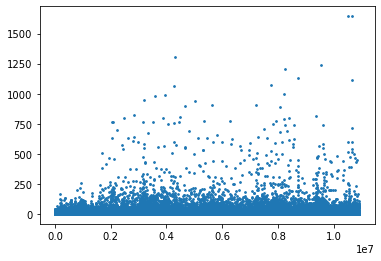

In [42]:
plt.scatter(np.array(range(10913804)),matrix.item_cnt_month,s=3)

In [43]:
matrix["item_cnt_month"] = matrix["item_cnt_month"].clip(0,20).astype(np.float16)
#time.time() - ts

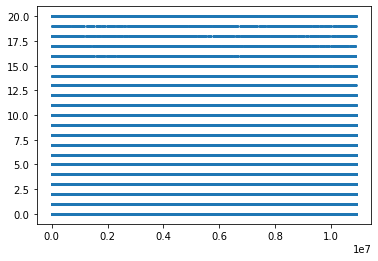

In [44]:
plt.scatter(np.array(range(10913804)),matrix.item_cnt_month,s=3)

In [45]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [46]:
test["date_block_num"] = 34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["shop_id"] = test.shop_id.astype(np.int8)
test["item_id"] = test.item_id.astype(np.int16)

In [47]:
matrix = pd.concat([matrix, test.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=cols)
matrix.fillna( 0, inplace = True )

In [48]:
matrix 

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.0
1,0,0,27,0.0
2,0,0,28,0.0
3,0,0,29,0.0
4,0,0,32,6.0
...,...,...,...,...
11127999,34,45,18454,0.0
11128000,34,45,16188,0.0
11128001,34,45,15757,0.0
11128002,34,45,19648,0.0


In [49]:
cats

,item_category_id,subtype_code,type_code
0,0,29,0
1,1,9,1
2,2,10,1
3,3,11,1
4,4,13,1
...,...,...,...
79,79,54,0
80,80,25,0
81,81,62,0
82,82,63,0


In [50]:
matrix = pd.merge( matrix, shops, on = ["shop_id"], how = "left" )
matrix = pd.merge(matrix, items, on = ["item_id"], how = "left")
matrix = pd.merge( matrix, cats, on = ["item_category_id"], how = "left" )

In [51]:
matrix["shop_city"] = matrix["shop_city"].astype(np.int8)
matrix["shop_category"] = matrix["shop_category"].astype(np.int8)
matrix["item_category_id"] = matrix["item_category_id"].astype(np.int8)
matrix["subtype_code"] = matrix["subtype_code"].astype(np.int8)
matrix["type_code"] = matrix["type_code"].astype(np.int8)

### 時系列遅れの特徴量の作成、特徴量の組み合わせ

In [52]:
def make_lag( df,lags, cols ):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", "shop_id","item_id",col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i#dateに1を足す、そしてこれを元のdfとmargeする。
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [53]:
matrix = make_lag( matrix, [1,2,3], ["item_cnt_month"] )

item_cnt_month


In [54]:
group = matrix.groupby( ["date_block_num"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_mean_item_cnt"]
group.reset_index(inplace = True)
matrix = pd.merge(matrix, group, on = ["date_block_num"], how = "left")
matrix.date_mean_item_cnt = matrix["date_mean_item_cnt"].astype(np.float16)
matrix = make_lag( matrix, [1], ["date_mean_item_cnt"] )
matrix.drop( ["date_mean_item_cnt"], axis = 1, inplace = True )

date_mean_item_cnt


In [55]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_mean_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix.date_item_mean_item_cnt = matrix['date_item_mean_item_cnt'].astype(np.float16)
matrix = make_lag(matrix, [1,2,3], ['date_item_mean_item_cnt'])
matrix.drop(['date_item_mean_item_cnt'], axis=1, inplace=True)

date_item_mean_item_cnt


In [56]:
group = matrix.groupby( ["date_block_num","shop_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_mean_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id"], how = "left")
matrix.date_mean_item_cnt = matrix["date_shop_mean_item_cnt"].astype(np.float16)
matrix = make_lag( matrix, [1,2,3], ["date_shop_mean_item_cnt"] )
matrix.drop( ["date_shop_mean_item_cnt"], axis = 1, inplace = True )

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


date_shop_mean_item_cnt


In [57]:
group = matrix.groupby( ["date_block_num","shop_id","item_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_item_mean_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id","item_id"], how = "left")
matrix.date_mean_item_cnt = matrix["date_shop_item_mean_item_cnt"].astype(np.float16)
matrix = make_lag( matrix, [1,2,3], ["date_shop_item_mean_item_cnt"] )
matrix.drop( ["date_shop_item_mean_item_cnt"], axis = 1, inplace = True )

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


date_shop_item_mean_item_cnt


In [58]:
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_mean_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix.date_shop_subtype_mean_item_cnt = matrix['date_shop_subtype_mean_item_cnt'].astype(np.float16)
matrix = make_lag(matrix, [1], ['date_shop_subtype_mean_item_cnt'])
matrix.drop(['date_shop_subtype_mean_item_cnt'], axis=1, inplace=True)

date_shop_subtype_mean_item_cnt


In [59]:
group = matrix.groupby(['date_block_num', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_city_mean_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', "shop_city"], how='left')
matrix.date_city_mean_item_cnt = matrix['date_city_mean_item_cnt'].astype(np.float16)
matrix = make_lag(matrix, [1], ['date_city_mean_item_cnt'])
matrix.drop(['date_city_mean_item_cnt'], axis=1, inplace=True)

date_city_mean_item_cnt


In [60]:
group = matrix.groupby(['date_block_num', 'item_id', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_mean_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'shop_city'], how='left')
matrix.date_item_city_mean_item_cnt = matrix['date_item_city_mean_item_cnt'].astype(np.float16)
matrix = make_lag(matrix, [1], ['date_item_city_mean_item_cnt'])
matrix.drop(['date_item_city_mean_item_cnt'], axis=1, inplace=True)

date_item_city_mean_item_cnt


In [61]:
group = train.groupby( ["item_id"] ).agg({"item_price": ["mean"]})
group.columns = ["item_mean_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge( group, on = ["item_id"], how = "left" )
matrix["item_mean_item_price"] = matrix.item_mean_item_price.astype(np.float16)


group = train.groupby( ["date_block_num","item_id"] ).agg( {"item_price": ["mean"]} )
group.columns = ["date_item_mean_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge(group, on = ["date_block_num","item_id"], how = "left")
matrix["date_item_mean_item_price"] = matrix.date_item_mean_item_price.astype(np.float16)

matrix = make_lag( matrix, [1], ["date_item_mean_item_price"] )

matrix["delta_price_lag_1"] = (matrix["date_item_mean_item_price_lag_1"]- matrix["item_mean_item_price"] )/ matrix["item_mean_item_price"]

date_item_mean_item_price


In [62]:
matrix["delta_price_lag"]=matrix["delta_price_lag_1"]

In [63]:
matrix["delta_price_lag"] = matrix.delta_price_lag.astype( np.float16 )
matrix["delta_price_lag"].fillna( 0 ,inplace = True)
features_to_drop = ["item_mean_item_price", "date_item_mean_item_price","date_item_mean_item_price_lag_1","date_item_mean_item_price_lag_1"]

In [64]:
matrix.drop(features_to_drop, axis = 1, inplace = True)

In [65]:
group = train.groupby( ["date_block_num","shop_id"] ).agg({"revenue": ["sum"] })
group.columns = ["date_shop_revenue"]
group.reset_index(inplace = True)
group


,date_block_num,shop_id,date_shop_revenue
0,0,0,2966412.00
1,0,1,1527320.00
2,0,2,1091137.01
3,0,3,560585.01
4,0,4,1437053.00
...,...,...,...
1581,33,55,1516423.00
1582,33,56,1327907.00
1583,33,57,2430180.00
1584,33,58,1763036.00


In [66]:
matrix = matrix.merge( group , on = ["date_block_num", "shop_id"], how = "left" )
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)
group = group.groupby(["shop_id"]).agg({ "date_shop_revenue":["mean"] })
group.columns = ["shop_mean_revenue"]
group.reset_index(inplace = True )

matrix = matrix.merge( group, on = ["shop_id"], how = "left" )
matrix["shop_mean_revenue"] = matrix.shop_mean_revenue.astype(np.float32)
matrix["delta_revenue"] = (matrix['date_shop_revenue'] - matrix['shop_mean_revenue']) / matrix['shop_mean_revenue']
matrix["delta_revenue"] = matrix["delta_revenue"]. astype(np.float32)

matrix = make_lag(matrix, [1], ["delta_revenue"])
matrix["delta_revenue_lag_1"] = matrix["delta_revenue_lag_1"].astype(np.float32)
matrix.drop( ["date_shop_revenue", "shop_mean_revenue", "delta_revenue"] ,axis = 1, inplace = True)

delta_revenue


In [67]:
matrix.head().T

,0,1,2,3,4
date_block_num,0,0,0,0,0
shop_id,0,0,0,0,0
item_id,19,27,28,29,32
item_cnt_month,0,0,0,0,6
shop_category,0,0,0,0,0
shop_city,0,0,0,0,0
item_name,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,"007 Legends [PS3, русская версия]","007 Legends [PС, Jewel, русская версия]","007 Legends [Xbox 360, русская версия]",1+1
item_category_id,40,19,30,23,40
subtype_code,4,10,55,16,4
type_code,5,3,3,3,5


In [68]:
matrix=matrix.drop("item_name",axis=1)

In [69]:
matrix["item_shop_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id","shop_id"])["date_block_num"].transform('min')
matrix["item_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id"])["date_block_num"].transform('min')

In [70]:
matrix.head().T

,0,1,2,3,4
date_block_num,0.0,0.0,0.0,0.0,0.0
shop_id,0.0,0.0,0.0,0.0,0.0
item_id,19.0,27.0,28.0,29.0,32.0
item_cnt_month,0.0,0.0,0.0,0.0,6.0
shop_category,0.0,0.0,0.0,0.0,0.0
shop_city,0.0,0.0,0.0,0.0,0.0
item_category_id,40.0,19.0,30.0,23.0,40.0
subtype_code,4.0,10.0,55.0,16.0,4.0
type_code,5.0,3.0,3.0,3.0,5.0
item_cnt_month_lag_1,NaN,NaN,NaN,NaN,NaN


In [71]:
matrix = matrix[matrix["date_block_num"] > 3]

## 勾配ブースティング

In [72]:
import os
import gc
import pickle
import time
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [73]:
data = matrix.copy()
del matrix
gc.collect()#メモリの再利用

9915

In [74]:
data[data["date_block_num"]==34].shape

(214200, 30)

In [75]:
data=data.fillna(0)

In [76]:
data[data["date_block_num"]==34].shape

(214200, 30)

In [77]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [78]:
del data
gc.collect();

In [79]:
ts = time.time()

model = XGBRegressor(
    max_depth=10,
    n_estimators=100,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

time.time() - ts

[12:01:00] WARNING: /workspace/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.15915	validation_1-rmse:1.11876
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.11824	validation_1-rmse:1.08327
[2]	validation_0-rmse:1.08340	validation_1-rmse:1.05038
[3]	validation_0-rmse:1.03903	validation_1-rmse:1.02451
[4]	validation_0-rmse:1.00713	validation_1-rmse:1.00257
[5]	validation_0-rmse:0.98250	validation_1-rmse:0.98448
[6]	validation_0-rmse:0.96142	validation_1-rmse:0.96857
[7]	validation_0-rmse:0.93978	validation_1-rmse:0.95734
[8]	validation_0-rmse:0.92352	validation_1-rmse:0.94534
[9]	validation_0-rmse:0.91066	validation_1-rmse:0.93765
[10]	validation_0-rmse:0.89738	validation_1-rmse:0.93393
[11]	va

2024.425645828247

In [80]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})


In [81]:
Y_test 

array([0.68146473, 0.50507194, 1.2532065 , ..., 0.07896015, 0.04822388,
       0.06996146], dtype=float32)

In [82]:
ls

__notebook_source__.ipynb


In [83]:
cd ../working

/kaggle/working


In [85]:
submission.to_csv('submission3.csv', index=False)